In [1]:
%%writefile task_09_game_of_life.py

import io
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


h_step = np.array((-1, -1, -1, 0, 0, 1, 1, 1), dtype=int)
w_step = np.array((-1, 0, 1, -1, 1, -1, 0, 1), dtype=int)

def step(X, ind_from, ind_to):
    h = X.shape[0]
    w = X.shape[1]
    res = np.zeros((ind_to - ind_from, w), dtype=int)
    for i in range(ind_from, ind_to):
        for j in range(w):
            res[i - ind_from][j] = X[(h_step + i) % h, (w_step + j) % w].sum()
    return (res == 3) | (X[ind_from:ind_to] & (res == 2))

def matrix_to_im_arr(M, results):
    buf = io.BytesIO()
    f = plt.figure(figsize=(14, 8))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.imshow(M, cmap='gray')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.plot(results)
    ax2.set_xticks(range(len(results)), minor=True)
    plt.savefig(buf, format="png")
    plt.close('all')
    buf.seek(0)
    return Image.open(buf)


# Glider gun
glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

GLIDER_GUN = np.zeros((50, 70), dtype=int)
GLIDER_GUN[2:11,1:37] = glider_gun

# Glider
glider = [[1, 0, 0],
          [0, 1, 1],
          [1, 1, 0]]
GLIDER = np.zeros((8, 8), dtype=int)
GLIDER[:3, :3] = glider

# Unbounded Growth
unbounded = [[1, 1, 1, 0, 1],
             [1, 0, 0, 0, 0],
             [0, 0, 0, 1, 1],
             [0, 1, 1, 0, 1],
             [1, 0, 1, 0, 1]]
UNBOUNDED = np.zeros((30, 40), dtype=int)
UNBOUNDED[15:20, 18:23] = unbounded

Writing task_09_game_of_life.py


In [2]:
import os
import io
import imageio
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from task_09_game_of_life import *

In [3]:
def get_animation(matrix, steps):
    M = matrix.copy()
    images = []
    results = []
    for i in range(steps):
        M = step(M, 0, M.shape[0])
        results.append(np.sum(M))
        images.append(matrix_to_im_arr(M, results))
    return images

### The "Gosper Glider Gun"

In [4]:
images = get_animation(GLIDER_GUN, steps=175)
imageio.mimsave('golder_gun.gif', images, fps=10)

![GIF](golder_gun.gif)

### The "Glider"

In [5]:
images = get_animation(GLIDER, steps=100)
imageio.mimsave('glider.gif', images, fps=4)

![GIF](glider.gif)

### Unbounded Growth

In [6]:
images = get_animation(UNBOUNDED, steps=100)
imageio.mimsave('unbounded_growth.gif', images, fps=4)

![GIF](unbounded_growth.gif)

## MPI

In [7]:
%%writefile task_09_game_of_life_mpi.py

import os
import io
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from mpi4py import MPI

from task_09_game_of_life import *


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False
STEPS = 2000
M = GLIDER_GUN

H = M.shape[0]
W = M.shape[1]

numDataPerRank = H // size

if IS_ROOT:
    numDataPerRank =  H - (numDataPerRank * (size - 1))

received = np.empty((numDataPerRank, W), dtype=int)
sendcounts = np.array(comm.gather(received.size, 0))

if not IS_ROOT:
    sendcounts = np.zeros(size, dtype=int)

comm.Bcast(sendcounts, root=0)
ind_from = np.sum(sendcounts[:rank]) // W
ind_to = np.sum(sendcounts[:rank+1]) // W

images = []
results_count = []

for i in range(STEPS):
    comm.Bcast(M, root=0)
    
    res = step(M, ind_from, ind_to)
    comm.Gatherv(res, (M, sendcounts), root=0)
        
    if IS_ROOT and IS_SAVE:
        results_count.append(np.sum(M))
        images.append(matrix_to_im_arr(M, results_count))

if IS_ROOT and IS_SAVE:
    imageio.mimsave('golder_gun.gif', images, fps=10)

Writing task_09_game_of_life_mpi.py


In [8]:
time_arr = []
processes = range(1, 9)
for i in processes:
    print(f'Num of processes: {i},\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_09_game_of_life_mpi.py
    time_arr.append(t.best)

Num of processes: 1,	39.1 s ± 714 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 2,	21 s ± 252 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 3,	15.5 s ± 143 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 4,	12.6 s ± 134 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 5,	9.82 s ± 125 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 6,	9.55 s ± 96.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 7,	7.89 s ± 135 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 8,	7.95 s ± 100 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'SpeedUp vs Num of processes')

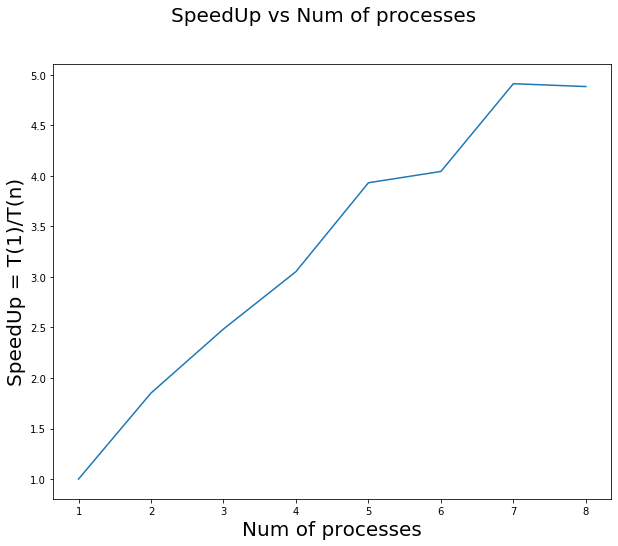

In [9]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)